In [34]:
#!/usr/bin/env python3
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import rcParamsDefault
import numpy as np
import csv
from numpy import pi as PI
from copy import deepcopy
import scienceplots
import pandas as pd

#Saving outputs for the group:
rcParams.update(rcParamsDefault)
results = [['Calculation', 'Result']]
pd.set_option('display.max_rows', None)  #???
FRAME = 63 #assumed to be peak flexion -> instant where ang velocity changes directions and corresponds to shortest spring length
results.append(['Chosen frame', 59])

In [35]:
class Plotter:

    def __init__(self):
        #CANVA BG COLOR: '#fbf6f1'
        plt.style.use(['science', 'notebook', 'grid'])
        plt.rcParams['figure.figsize'] = [10, 6]
        plt.rcParams['axes.facecolor'] = '#FFFFFF'
        plt.rcParams['savefig.facecolor']='#FFFFFF'
        

        

    def plotOutput(self, calculation, patientComparison=None, winters=None, stressComparison=None):
        plt.clf()
        fg, ax = plt.subplots(1,1)
        fg
        ax.set_title(calculation.title_long)
        ax.set_xlabel("Gait Cycle [%]")
        ax.set_ylabel("{} [{}]".format(calculation.title, calculation.units))
        ax.grid(axis='y')

        ax.plot(calculation.x, calculation.output, '-', lw=2.5, ms=2, color='#348ABD')
        self.callout(calculation=calculation)
        if patientComparison:
           ax.plot(calculation.x, patientComparison.output, '-', lw=2.5, ms=2, color='#A60628')

        if winters:
            ax.legend(['Healthy Patient',"Winter's Data"], fontsize=10, fancybox=False, edgecolor='black')
        else:
            ax.legend(['Normal Gait','Assisted Gait'], fontsize=10, fancybox=False, edgecolor='black') 

        ax.set_ylim(calculation.ylim)
        ax.set_xlim(0, 100)
        plt.savefig(f"graphs/{calculation.title_long}", dpi=300)
        plt.show()

    def plotThreeOutput(self, calculation1, calculation2, calculation3, patientComparison=None, winters=None, momentSavings=None):
        plt.clf()
        fg, ax = plt.subplots(1,3)
        fg
        ax.set_title(calculation.title_long)
        ax.set_xlabel("Gait Cycle [%]")
        ax.set_ylabel("{} [{}]".format(calculation.title, calculation.units))
        ax.grid(axis='y')

        ax.plot(calculation.x, calculation.output, '-', lw=2.5, ms=2, color='#348ABD')
        self.callout(calculation=calculation)
        if patientComparison:
           ax.plot(calculation.x, patientComparison.output, '-', lw=2.5, ms=2, color='#A60628')

        if winters:
            ax.legend(['Healthy Patient',"Winter's Data"], fontsize=10, fancybox=False, edgecolor='black')
        elif momentSavings:
            ax.legend(['Normal Gait', 'Assisted Gait'],fontsize=10, fancybox=False, edgecolor='black') #changed
        elif patientComparison:
            ax.legend(['Normal Gait', 'Assisted Gait'], fontsize=10, fancybox=False, edgecolor='black') #changed
        else:
            ax.legend(['Normal Gait','Assisted Gait'], fontsize=10, fancybox=False, edgecolor='black') #changed

        ax.set_ylim(calculation.ylim)
        ax.set_xlim(0, 100)
        plt.savefig(f"graphs/{calculation.title_long}", dpi=300)
        plt.show()

    def callout(self, calculation, ax=None):
        ymin, ymax = min(calculation.output), max(calculation.output)
        xpos_min, xpos_max = np.argmin(calculation.output), np.argmax(calculation.output)
        x_min, x_max = calculation.x[xpos_min], calculation.x[xpos_max]
        
        text_min = "Frame {:.0f}, {:.3f} {units}".format(xpos_min+1, ymin, units=calculation.units)
        text_max = "Frame {:.0f}, {:.3f} {units}".format(xpos_max+1, ymax, units=calculation.units)
        
        if not ax:
            ax=plt.gca()

        #bbox_props = dict(facecolor='#FFFAF5', edgecolor='black')
        bbox_props = dict(facecolor='#FFFFFF', edgecolor='black')

        arrowprops=dict(
                arrowstyle="-|>",
                connectionstyle="angle,angleA=0,angleB=90",
                color='k')

        kw = dict(
                xycoords='data',
                textcoords="axes fraction",
                arrowprops=arrowprops,
                bbox=bbox_props,
                ha="right",
                va="top")

        plt.annotate(text_max, xy=(x_max, ymax), xytext=(0.4,0.94), **kw)
        plt.annotate(text_min, xy=(x_min, ymin), xytext=(0.75,0.06), **kw)

plotter = Plotter()
plotter

In [36]:
class Calculation:
    def __init__(self, patient, implant=None, title=None, title_long=None, units=None, ylim=None):
        self.title = title
        self.title_long = title_long
        self.units = units
        self.ylim = ylim
        self.output = np.empty(0)
        self.x = np.arange(0,70) # number of frames 
        self.x = 100*self.x/69  #divide by number of frames -1
        self.patient = patient

In [37]:
class Patient:

    def __init__(self,winters_data,mass,height,coefficient):

        #initialize patient properties
        self.mass = mass        #kg
        self.height = height    #m
        self.spring_coff = coefficient #N/cm
        self.hipRx = []
        self.hipRy = []
        self.hipM = []
        self.hipRx_asst = []
        self.hipRy_asst = []
        self.hipM_asst = []
        self.hipM_diff = []

        #initialize dynamic analysis data to a dict
        self.dynamic = {}
        with open(winters_data, mode='r') as file:
            csv_reader = csv.DictReader(file)
            for row in csv_reader:
                frame = int(row['Frame'])
                del row['Frame']
                for key, value in row.items():
                    row[key] = float(value)
                self.dynamic[frame] = row

        #initialize Lengths, Masses, Weights
        self.L_foot = 0.152*self.height
        self.L_shank = (0.285-0.039)*self.height
        self.L_thigh = (0.53-0.285)*self.height
        self.m_foot = 0.0145*self.mass
        self.m_shank = 0.0465*self.mass
        self.m_thigh = 0.1*self.mass
        self.w_foot = self.m_foot*G
        self.w_shank = self.m_shank*G
        self.w_thigh = self.m_thigh*G

        # added properties for exoskeleton
        self.LA_length = 14 #cm
        self.cuff_disp = 7/8*self.L_thigh #cm, distance of cuff from knee 
        self.spring_length = []
        self.spring_force = []  #N 
        self.spring_x_force = []
        self.spring_y_force = []
        self.thigh_angle = []
        self.thigh_length = []
        self.cable_thigh_angle = []

        #self.peak_flexion = self.dynamic[FRAME]
        self.peak_flexion = self.dynamic[1]  #row 1 corresponds to peak flexion in left_right_data_healthy.csv
        og_thigh_length = np.sqrt(pow((self.peak_flexion["HipY"]-self.peak_flexion["KneeY"]), 2) + pow((self.peak_flexion["HipX"]-self.peak_flexion["KneeX"]), 2))
        print("og thigh length: ", og_thigh_length)

        og_cuff_X_pos = self.peak_flexion["HipX"] + (self.cuff_disp)*abs(np.cos(self.peak_flexion["angle"]/180*PI))
        og_cuff_Y_pos = self.peak_flexion["HipY"] - (self.cuff_disp)*abs(np.sin(self.peak_flexion["angle"]/180*PI))
        self.og_spring = np.sqrt(pow((self.LA_length + self.peak_flexion["HipX"]- og_cuff_X_pos), 2) + pow((self.peak_flexion["HipY"]- og_cuff_Y_pos), 2))

        print("Orginal spring length",self.og_spring)
        print("coords : ", og_cuff_X_pos," , ", og_cuff_Y_pos)


        
        for index in range(len(self.dynamic)):
            frame = index+1
            d = self.dynamic[frame] #d for data

            #geometry
            GRF_pos = [d["GroundCoFPX"],0]
            Ankle_pos = [d["AnkleX"]/100,d["AnkleY"]/100]
            Foot_CoM_pos = [d["FootCoMX"],d["FootCoMY"]]
            Knee_pos = [d["KneeX"]/100,d["KneeY"]/100]
            Leg_CoM_pos = [d["LegCoMX"],d["LegCoMY"]]
            Hip_pos = [d["HipX"]/100,d["HipY"]/100]
            Thigh_CoM_pos = [d["ThighCoMX"],d["ThighCoMY"]]

            curr_thigh_angle = d["angle"]*PI/180 # previously calculated in .csv


            Thigh_length = np.sqrt((pow((d["HipY"]-d["KneeY"]), 2) + pow((d["HipX"]-d["KneeX"]), 2)))
            self.thigh_length.append(Thigh_length)

            # where self.cuff_disp = 7/8*self.L_thigh 
            if (d["HipX"] > d["KneeX"]) :
                cuff_X_pos = d["HipX"] - (Thigh_length - self.cuff_disp)*abs(np.cos(curr_thigh_angle))
                cuff_Y_pos = d["HipY"] - (Thigh_length - self.cuff_disp)*abs(np.sin(curr_thigh_angle))
            else :
                cuff_X_pos = d["HipX"] + (Thigh_length - self.cuff_disp)*abs(np.cos(curr_thigh_angle))
                cuff_Y_pos = d["HipY"] - (Thigh_length - self.cuff_disp)*abs(np.sin(curr_thigh_angle))
    
            cuff_pos = [cuff_X_pos/100, cuff_Y_pos/100]
              
            # INVERSE DYNAMICS FROM GROUND REACTION FORCES
            # normalize ground reaction forces and multiply by patient's mass 
            GRF = np.array([(mass/56.7)*d["GroundRX"],(mass/56.7)*d["GroundRY"]])
    
            #ankle frame
            F_ankle = [self.m_foot*d["FootAX"], self.m_foot*d["FootAY"]] - GRF - [0,self.w_foot]
            I_foot = ((0.475*self.L_foot)**2)*self.m_foot
            r_af = np.subtract(Ankle_pos,Foot_CoM_pos)
            r_gf = np.subtract(GRF_pos,Foot_CoM_pos)
            M_ankle = d["FootAA"]*I_foot - np.cross(r_af, F_ankle) - np.cross(r_gf, GRF)
            
            #leg frame
            F_ankle = F_ankle*-1
            M_ankle = M_ankle*-1
    
            F_knee = [self.m_shank*d["LegAX"], self.m_shank*d["LegAY"]] - F_ankle - [0,self.w_shank] 
            I_shank = ((0.302*self.L_shank)**2)*self.m_shank
            r_al = np.subtract(Ankle_pos,Leg_CoM_pos)
            r_kl = np.subtract(Knee_pos,Leg_CoM_pos)
            M_knee = d["LegAA"]*I_shank - np.cross(r_al, F_ankle) - np.cross(r_kl, F_knee) - M_ankle
            
            #thigh frame
            F_knee = F_knee*-1 
            M_knee = M_knee*-1 
            
            F_hip = [self.m_thigh*d["ThighAX"], self.m_thigh*d["ThighAY"]] - F_knee - [0, self.w_thigh]
            I_thigh = ((0.323*self.L_thigh)**2)*self.m_thigh 
            M_hip = d["ThighAA"]*I_thigh - np.cross(np.subtract(Knee_pos,Thigh_CoM_pos),F_knee) - np.cross(np.subtract(Hip_pos,Thigh_CoM_pos),F_hip) - M_knee
           
            
            self.hipRx.append(F_hip[0])
            self.hipRy.append(F_hip[1])
            self.hipM.append(M_hip)

            # spring extension

            spring_x_length = (self.LA_length + np.subtract(d["HipX"],cuff_X_pos))
            spring_y_length = (np.subtract(d["HipY"], cuff_Y_pos))
            self.spring_length.append(np.sqrt(pow(spring_x_length, 2)+pow(spring_y_length,2)))
            
            cable_LA_angle = np.arctan(spring_y_length/spring_x_length)
            cable_thigh_angle = PI -curr_thigh_angle - cable_LA_angle
            self.thigh_angle.append(curr_thigh_angle)
            self.cable_thigh_angle.append(cable_thigh_angle)
 
            #spring_force = -1*self.spring_coff*(self.og_spring -np.sqrt(pow(spring_x_length, 2)+pow(spring_y_length,2)) )
            spring_force = self.spring_coff*(d["average_spring_length"]-self.og_spring ) #average refers to average between both legs for current frame of gait cycle  
            self.spring_force.append(spring_force)
            self.spring_x_force.append(spring_force*np.cos(cable_LA_angle))
            self.spring_y_force.append(spring_force*np.sin(cable_LA_angle))
            spring_force_xy = [spring_force*np.cos(cable_LA_angle),spring_force*np.sin(cable_LA_angle)]

            # assisted reachtion forces and moment at hip 
            F_hip_new = [self.m_thigh*d["ThighAX"], self.m_thigh*d["ThighAY"]] - F_knee - [0, self.w_thigh] - spring_force_xy
            M_hip_new = d["ThighAA"]*I_thigh - np.cross(np.subtract(Knee_pos,Thigh_CoM_pos),F_knee) - np.cross(np.subtract(Hip_pos,Thigh_CoM_pos),F_hip_new) - np.cross(np.subtract(cuff_pos,Thigh_CoM_pos),spring_force_xy)- M_knee
            
            
            self.hipRx_asst.append(F_hip_new[0])
            self.hipRy_asst.append(F_hip_new[1])
            self.hipM_asst.append(M_hip_new)
            self.hipM_diff.append(M_hip-M_hip_new)

        

        self.thigh_length = np.array(self.thigh_length)
        self.spring_length = np.array(self.spring_length)
        self.spring_force = np.array(self.spring_force)
        self.spring_x_force = np.array(self.spring_x_force)
        self.spring_y_force =np.array(self.spring_y_force)
        self.thigh_angle = np.array(self.thigh_angle)
        self.cable_thigh_angle = np.array(self.cable_thigh_angle)

        
        combined = np.stack([ self.thigh_length, self.spring_length, self.spring_force, self.spring_x_force,self.spring_y_force, self.thigh_angle, self.cable_thigh_angle],1)
        new_param = pd.DataFrame(combined, columns=['thigh_length','spring_length','spring_force', 'spring_x_force', 'spring_y_force', 'thigh_angle', 'cable_thigh_angle'] )
        new_param.index = new_param.index + 1
        new_param.to_csv(index=True)
        
        
        new_param_csv = new_param.to_csv('double_spring_gait_parameters.csv', index = True) 
        #print('\nCSV String:\n', new_param_csv) 


        self.hipRx = np.array(self.hipRx)
        self.hipRy = np.array(self.hipRy)
        self.hipM = np.array(self.hipM)
        self.hipResultant = (self.hipRx**2 + self.hipRy**2)**(1/2)

        self.hipRx_asst = np.array(self.hipRx_asst)
        self.hipRy_asst = np.array(self.hipRy_asst)
        self.hipM_asst = np.array(self.hipM_asst)
        self.hipM_diff = np.array(self.hipM_diff)

        # MATLAB OUTPUTS
        print("max x force: " , np.max(self.spring_x_force))
        print("max y force: ", np.max(self.spring_y_force))
        print("min x force",  np.min(self.spring_x_force) )
        print(" min y force ",  np.min(self.spring_y_force))
        
        
        max_force = new_param.loc[new_param['spring_force'] ==  np.max(self.spring_force)]
        min_force = new_param.loc[new_param['spring_force'] ==  np.min(self.spring_force)]
        max_x_force = new_param.loc[new_param['spring_x_force'] ==  np.max(self.spring_x_force)]
        max_y_force = new_param.loc[new_param['spring_y_force'] ==  np.max(self.spring_y_force)]
        min_x_force = new_param.loc[new_param['spring_x_force'] ==  np.min(self.spring_x_force)]
        min_y_force = new_param.loc[new_param['spring_y_force'] ==  np.min(self.spring_y_force)]
        index_ =pd.Series(["max_force","min_force","max_x_force", "max_y_force", "min_x_force", "min_y_force"])
        min_max_param = [max_force, min_force, max_x_force, max_y_force, min_x_force, min_y_force]
        matlab_input = pd.concat(min_max_param).set_index(index_)

        matlab_input.to_csv('python_gait_output.csv')


In [38]:
#OUR PATIENT
patientMass = 85.3 #kg
patientHeight = 1.731 #m

#CONSTANTS 
G = -9.81


healthyElder = Patient(
        mass=patientMass,
        height=patientHeight,
        coefficient=5,
        winters_data='left_right_data_healthy.csv')

heavyUser = Patient(
        mass=119.62,
        height=1.895,
        coefficient=5,
        winters_data='left_right_data_healthy.csv')

lightUser = Patient(
        mass=60.5,
        height=161.50,
        coefficient=5,
        winters_data='left_right_data_healthy.csv')

results.append(['Fx', healthyElder.hipRx[FRAME]])
results.append(['Fy', healthyElder.hipRy[FRAME]])
results.append(['M', healthyElder.hipM[FRAME]])

#injuredElder = Patient(
#        mass=patientMass,
#        height=patientHeight,
#        winters_data='data_injured.csv')

og thigh length:  31.247030258890213
Orginal spring length 13.839278212157838
coords :  79.3547171875769  ,  82.31747791986618
max x force:  33.66127475156636
max y force:  54.82657810997084
min x force 0.5107379359807993
 min y force  40.87864250953634
og thigh length:  31.247030258890213
Orginal spring length 13.824470627605969
coords :  79.37032297542358  ,  82.28597380597714
max x force:  33.72142773714617
max y force:  54.8945538790651
min x force 0.5392233713597326
 min y force  40.932773036194156
og thigh length:  31.247030258890213
Orginal spring length 31.05401000260644
coords :  94.55789473926522  ,  51.62613174950179
max x force:  -29.656226908902564
max y force:  9.844097002626507
min x force -39.937732131868216
 min y force  5.831538132341049


<Figure size 1000x600 with 0 Axes>

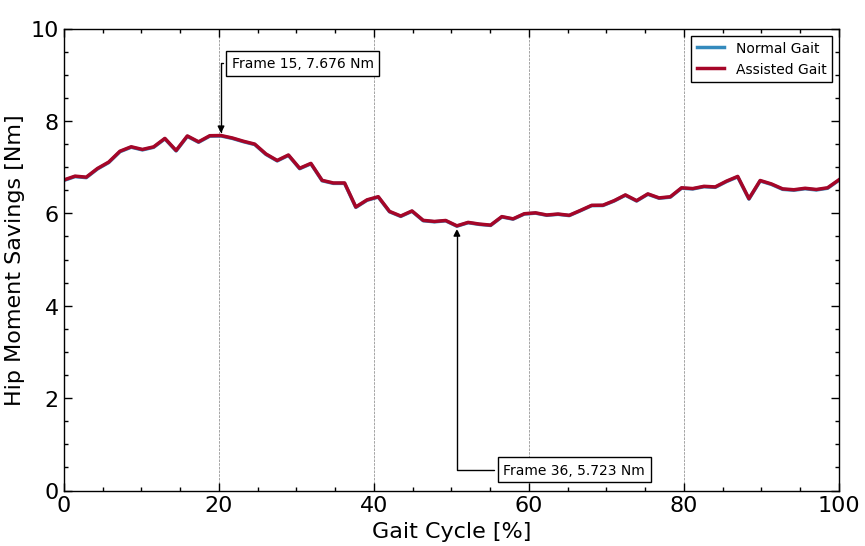

In [39]:
hip_moment_diff= Calculation(
        patient = healthyElder,
        title = "Hip Moment Savings",
        title_long = " ",
        ylim = [0,10],
        units = "Nm")
hip_moment_diff.output = hip_moment_diff.patient.hipM_diff
hip_moment_diff_heavy= Calculation(
        patient = heavyUser,
        title = "Hip Moment Savings",
        title_long = " ",
        ylim = [0,10],
        units = "Nm")
hip_moment_diff_heavy.output = hip_moment_diff_heavy.patient.hipM_diff
plotter.plotOutput(calculation=hip_moment_diff, patientComparison=hip_moment_diff_heavy)
#plotter.plotOutput(calculation=hip_moment_diff_heavy)

<Figure size 1000x600 with 0 Axes>

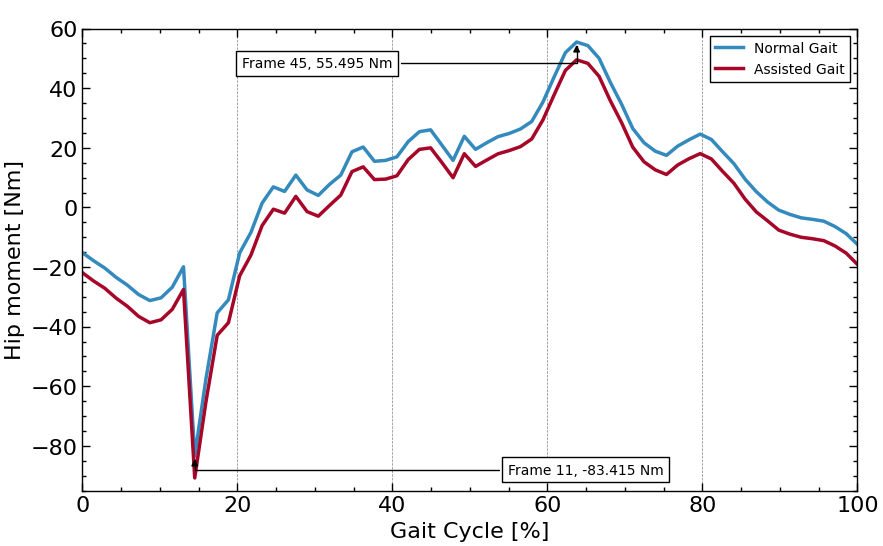

In [40]:
hip_moment_asst= Calculation(
        patient = healthyElder,
        title = "Hip moment",
        title_long = " ",
        ylim = [-95,60],
        units = "Nm")
hip_moment_asst.output = hip_moment_asst.patient.hipM_asst

hip_moment_og= Calculation(
        patient = healthyElder,
        title = "Hip moment",
        title_long = " ",
        ylim = [-95,60],
        units = "Nm")
hip_moment_og.output = hip_moment_og.patient.hipM
#plotter.plotOutput(calculation=mSpecificHealthy, patientComparison=mSpecificInjured)
plotter.plotOutput(calculation=hip_moment_og, patientComparison=hip_moment_asst)

<Figure size 1000x600 with 0 Axes>

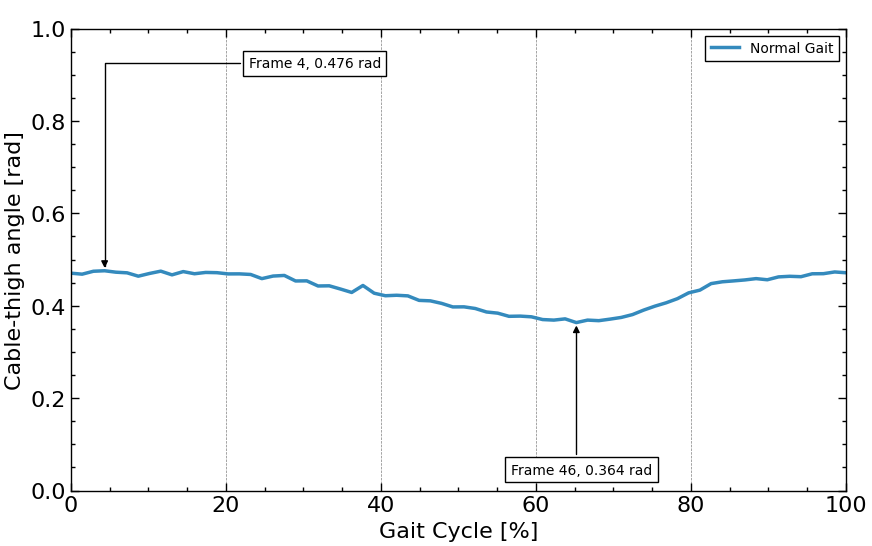

In [41]:
cable_angle_gait = Calculation(
        patient = healthyElder,
        title = "Cable-thigh angle",
        title_long = " ",
        ylim = [0,1],
        units = "rad")
cable_angle_gait.output = cable_angle_gait.patient.cable_thigh_angle

plotter.plotOutput(calculation=cable_angle_gait)

<Figure size 1000x600 with 0 Axes>

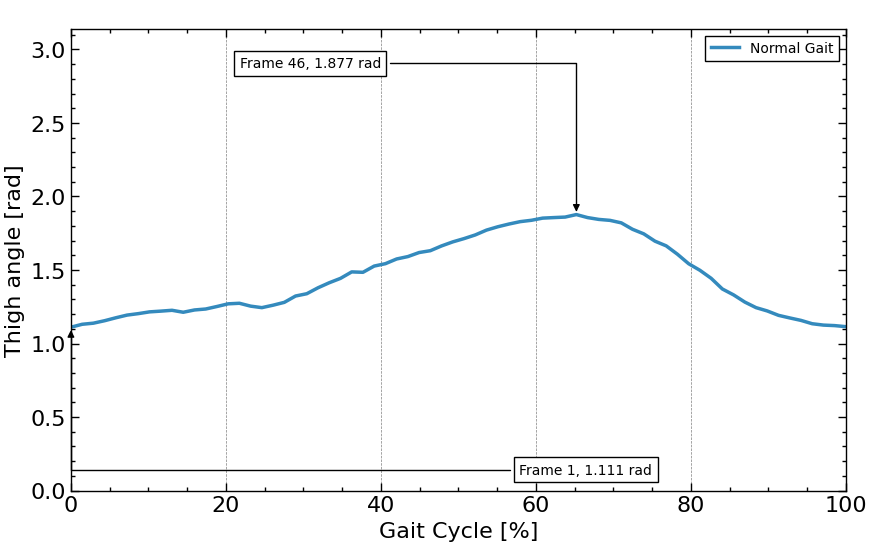

In [42]:
thigh_angle_gait = Calculation(
        patient = healthyElder,
        title = "Thigh angle",
        title_long = " ",
        ylim = [0,PI],
        units = "rad")
thigh_angle_gait.output = thigh_angle_gait.patient.thigh_angle

plotter.plotOutput(calculation=thigh_angle_gait)

<Figure size 1000x600 with 0 Axes>

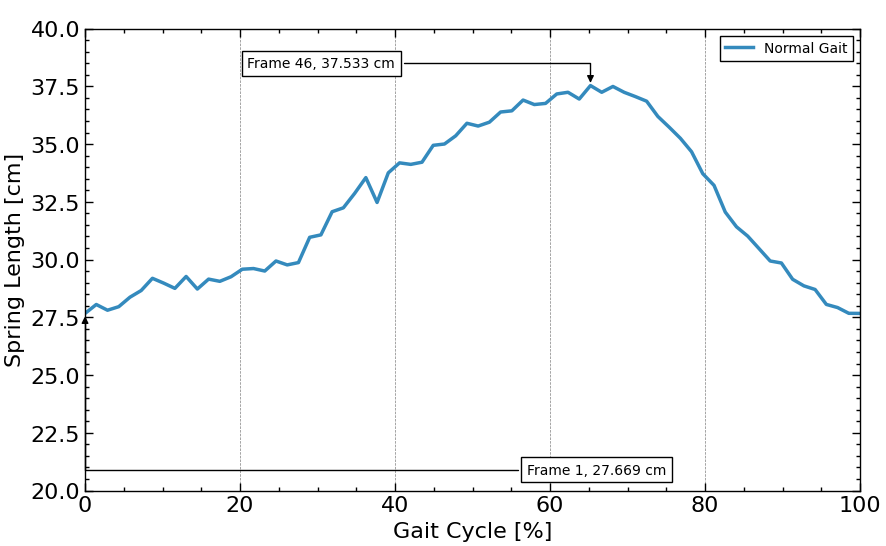

In [43]:
spring_length_gait = Calculation(
        patient = healthyElder,
        title = "Spring Length",
        title_long = " ",
        ylim = [20,40],
        units = "cm")
spring_length_gait.output = spring_length_gait.patient.spring_length

plotter.plotOutput(calculation=spring_length_gait)

<Figure size 1000x600 with 0 Axes>

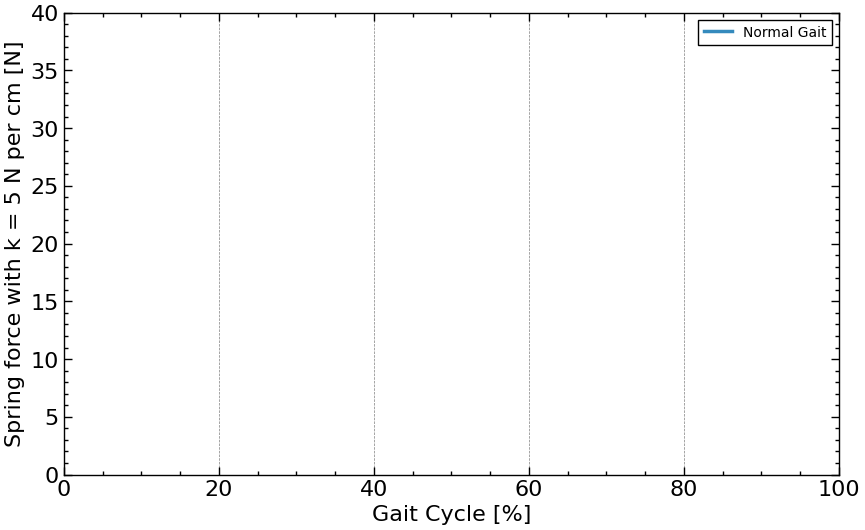

In [44]:
spring_force_gait = Calculation(
        patient = healthyElder,
        title = "Spring force with k = 5 N per cm",
        title_long = "",
        ylim = [0,40],
        units = "N")
spring_force_gait.output = spring_force_gait.patient.spring_force

plotter.plotOutput(calculation=spring_force_gait)